In [1]:
import numpy as np
import pandas as pd
import math

In [2]:
##############################################################
# Data munging 


# hmda_init() – Read the data files and return a pointer or 
# object containing the expanded HMDA data
##############################################################
def hmda_init(loanfile=r"E:\JOB\Job_Application_Materials\Interview_by_company\Capital One\data-challenge-data-master\data_copy\2012_to_2014_loans_data.csv",
              institutionfile=r"E:\JOB\Job_Application_Materials\Interview_by_company\Capital One\data-challenge-data-master\data_copy\2012_to_2014_institutions_data.csv"):
    
    """
    This function infiles data from .csv into pandas DataFrame
    
    Parameters
    ----------
    loanfile, string
        the location path of the loans csv file
        
    institutionfile, string
        the location path of the institution csv file
        
    """
    ##############################################################
    # infile csv files
    ##############################################################
    
    # read in loan csv file
    loans = pd.read_csv(loanfile,
                        header=0,
                        low_memory=False)
    
    # fix up the format
    
    # a function make input list of columns to object format
    def toObj(s,data):
        """
        a function make input list of columns to object format

        Parameters
        ----------
        s, list
            list of column names

        data, DataFrame
            name of the dataset
        """
        for col in s:
            data[col] = data[col].astype(object)

        
    # a function make input list of columns to float format
    def objToFloat(s,data):
        """
        a function make input list of columns to float format.
        It takes care of np.nan format. Since np.nan is float format,
        the format for the numeric columns with np.nan value is float
        instead of int

        Parameters
        ----------
        s, list
            list of column names

        data, DataFrame
            name of the dataset
            
        Returns
        ----------
        DataFrame
        """
        for col in s:
            # check the abnormal value
            data[col].value_counts()

            # change 'NA  ' into np.nan
            data[col] = data[col].apply(
                lambda x: np.nan if isinstance(x,str) and x.strip()=='NA' else x)

            # str to float
            data[col] = data[col].astype(float)
            
    # fix the object columns
    colList = ['Agency_Code',
               'Census_Tract_Number',
               'County_Code',
               'MSA_MD',
               'Respondent_ID',
               'Sequence_Number',
               'State_Code',
               'MSA_MD_Description',
               'Loan_Purpose_Description',
               'Agency_Code_Description',
               'Lien_Status_Description',
               'Loan_Type_Description',
               'State',
               'County_Name',
               'Conventional_Status',
               'Conforming_Status',
               'Conventional_Conforming_Flag']
    
    # this function changes the list of the columns into object format
    toObj(s=colList, data=loans)

    # fix the numeric columns
    colList = ['Applicant_Income_000', 
               'FFIEC_Median_Family_Income',
               'Number_of_Owner_Occupied_Units',
               'Tract_to_MSA_MD_Income_Pct']
    # a function make input list of columns to float format, takes care of NA values.
    objToFloat(s=colList, data=loans)

    
    # infile institution data
    institution = pd.read_csv(institutionfile,
                        header=0,
                        low_memory=False)

    # change integer to object
    colList = ['Agency_Code']
    
    # this function changes the list of the columns into object format
    toObj(s=colList, data=institution)

    ##############################################################
    # Join loan data and insititution data
    ##############################################################
    # join key: As_of_Year + Agency_code + Respondent_ID
    df = loans.merge(right=institution, how='left',
                     left_on=['As_of_Year','Agency_Code','Respondent_ID'],
                     right_on=['As_of_Year','Agency_Code','Respondent_ID'])

    ##############################################################
    # Bucket loan amount
    ##############################################################
    df['Loan_Amount_Bucket'] = (df['Loan_Amount_000']/100+0.5).round() # round up
    # if > 1000k, put them into same bucket
    df.loc[df['Loan_Amount_Bucket'] > 10] = 11
    
    return df

In [3]:
# infile csv into DataFrame
df_hmda = hmda_init()
df_hmda.head()
df_hmda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1321158 entries, 0 to 1321157
Data columns (total 34 columns):
Agency_Code                       1321158 non-null object
Applicant_Income_000              1203484 non-null float64
As_of_Year                        1321158 non-null int64
Census_Tract_Number               1321158 non-null object
County_Code                       1321158 non-null object
FFIEC_Median_Family_Income        1319511 non-null float64
Loan_Amount_000                   1321158 non-null int64
MSA_MD                            1321158 non-null object
Number_of_Owner_Occupied_Units    1319321 non-null float64
Respondent_ID                     1321158 non-null object
Sequence_Number                   1321158 non-null object
State_Code                        1321158 non-null object
Tract_to_MSA_MD_Income_Pct        1319348 non-null float64
MSA_MD_Description                1226239 non-null object
Loan_Purpose_Description          1321158 non-null object
Agency_Code_Des

In [ ]:
##############################################################
# Data munging 


#  hmda_to_json(data, states, conventional_conforming) – Export the 
# expanded data set to disk for the states filtered by product segment. Both 
# parameters are optional
##############################################################
def hmda_to_json(data, states=None, conventional_conforming=None, 
                 output = "E:\JOB\Job_Application_Materials\Interview_by_company\Capital One\data-challenge-data-master\data_copy\data_query.csv"):
    """
    This function export the expanded data set to disk for the states filtered by product segment.
    
    Parameters
    ----------
    data, DataFrame
        name of the DataFrame
        
    states, list
        list of states
    
    conventional_conforming, string
        'Y' or 'N'
    
    output: filepath = "C:/Users/Chen/Desktop/data-challenge-data-master/data-challenge-data-master/data_query.csv"

    Returns
    ---------
    dataset in csv format
    """
    if states:
        new_data = data[data['State'].apply(lambda x: x in states)]
    else:
        new_data = data
        
    if conventional_conforming:
        new_data1 = new_data[new_data['Conventional_Conforming_Flag'] == conventional_conforming]
        
    new_data1.to_csv(output)

In [32]:
# Test the function
# export the expanded data set to disk for the states filtered by product segment
hmda_to_json(df_hmda,['VA','DC'],'Y')

In [4]:
##############################################################
# Quality check 

# Data cleaning
##############################################################
 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# drop duplicates
df_hmda1 = df_hmda.drop_duplicates(keep='first')

In [9]:
df_hmda1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1312989 entries, 0 to 1320857
Data columns (total 34 columns):
Agency_Code                       1312989 non-null object
Applicant_Income_000              1195315 non-null float64
As_of_Year                        1312989 non-null int64
Census_Tract_Number               1312989 non-null object
County_Code                       1312989 non-null object
FFIEC_Median_Family_Income        1311342 non-null float64
Loan_Amount_000                   1312989 non-null int64
MSA_MD                            1312989 non-null object
Number_of_Owner_Occupied_Units    1311152 non-null float64
Respondent_ID                     1312989 non-null object
Sequence_Number                   1312989 non-null object
State_Code                        1312989 non-null object
Tract_to_MSA_MD_Income_Pct        1311179 non-null float64
MSA_MD_Description                1218070 non-null object
Loan_Purpose_Description          1312989 non-null object
Agency_Code_Des

In [10]:
# Descriptive statistics of numeric variables

# count NaN values of each variables
sr = 100*df_hmda1.isnull().sum()/1312989 #total number of entries 1312989
sr.sort_values(ascending=False)

# 8.96% of missing values of applicant_income

Parent_City_TS                    50.473157
Parent_Name_TS                    50.473157
Parent_State_TS                   50.462342
Parent_ZIP_Code                   50.430202
Applicant_Income_000               8.962299
MSA_MD_Description                 7.229230
Number_of_Owner_Occupied_Units     0.139910
Tract_to_MSA_MD_Income_Pct         0.137853
FFIEC_Median_Family_Income         0.125439
Conforming_Limit_000               0.063672
County_Name                        0.063672
County_Code                        0.000000
Census_Tract_Number                0.000000
Loan_Amount_000                    0.000000
MSA_MD                             0.000000
As_of_Year                         0.000000
Respondent_ID                      0.000000
Sequence_Number                    0.000000
State_Code                         0.000000
Loan_Amount_Bucket                 0.000000
Lien_Status_Description            0.000000
Loan_Purpose_Description           0.000000
Agency_Code_Description         

In [11]:
# descriptive statistics of numeric variables
df_hmda1.describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.99],include=[np.number]).transpose()

# unreasonable min value of  As_of_Year, Applicant_Income_000, Loan_Amount_000, Conforming_Limit_000
# will check these these variables

C:\Users\YG\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
Applicant_Income_000,1195315.0,1.149355e+02,1.032776e+02,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.999000e+03
As_of_Year,1312989.0,2.012795e+03,1.911166e+00,11.00,2012.0,2012.0,2012.0,2013.0,2013.0,2.014000e+03,2.014000e+03,2.014000e+03
FFIEC_Median_Family_Income,1311342.0,8.759453e+04,1.953677e+04,11.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.134000e+05
Loan_Amount_000,1312989.0,2.631222e+02,1.538755e+02,1.00,30.0,99.0,153.0,233.0,344.0,4.590000e+02,7.690000e+02,1.000000e+03
Number_of_Owner_Occupied_Units,1311152.0,1.383851e+03,5.657789e+02,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.632000e+03
Tract_to_MSA_MD_Income_Pct,1311179.0,1.167828e+02,3.737112e+01,4.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.506700e+02
Conforming_Limit_000,1312153.0,5.325683e+02,8.689155e+01,11.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.250000e+02
Assets_000_Panel,1312989.0,3.007767e+08,5.480965e+08,0.00,3295.0,10000.0,10000.0,1835386.0,178034172.0,1.288658e+09,1.896773e+09,1.945467e+09
Loan_Amount_Bucket,1312989.0,3.133861e+00,1.564779e+00,1.00,1.0,1.0,2.0,3.0,4.0,5.000000e+00,8.000000e+00,1.100000e+01


In [12]:
################################ 
# check the value of as_of_year
################################

df_hmda1['As_of_Year'].value_counts(normalize=True,sort=True, ascending=False, bins=None, dropna=True)

2012    4.227294e-01
2013    3.580060e-01
2014    2.192638e-01
11      7.616210e-07
Name: As_of_Year, dtype: float64

In [13]:
# check the the row with year=11

df_hmda1[df_hmda1['As_of_Year']==11]

,Agency_Code,Applicant_Income_000,As_of_Year,Census_Tract_Number,County_Code,FFIEC_Median_Family_Income,Loan_Amount_000,MSA_MD,Number_of_Owner_Occupied_Units,Respondent_ID,...,Respondent_Name_TS,Respondent_City_TS,Respondent_State_TS,Respondent_ZIP_Code,Parent_Name_TS,Parent_City_TS,Parent_State_TS,Parent_ZIP_Code,Assets_000_Panel,Loan_Amount_Bucket
691,11,11.0,11,11,11,11.0,11,11,11.0,11,...,11,11,11,11,11,11,11,11,11,11.0


In [14]:
# delete the rwo of as of year = 10
df_hmda1.drop(df_hmda1[df_hmda1['As_of_Year']==11].index, inplace=True, axis=0)

C:\Users\YG\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [15]:
df_hmda1['As_of_Year'].value_counts(normalize=True,sort=True, ascending=False, bins=None, dropna=True)

2012    0.422730
2013    0.358006
2014    0.219264
Name: As_of_Year, dtype: float64

In [16]:
########################################
# distribution of Conforming_Limit_000
########################################
df_hmda1['Conforming_Limit_000'].min()

417.0

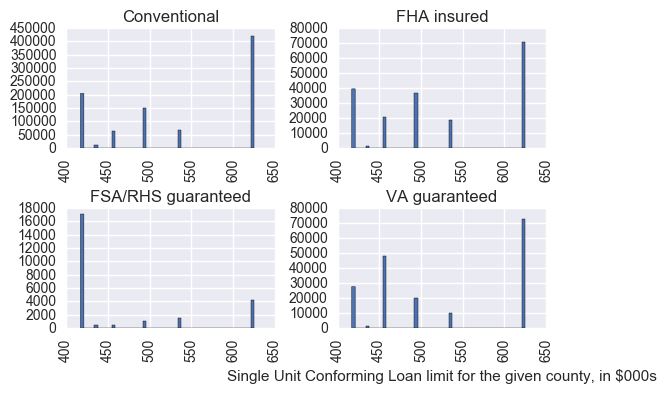

In [17]:
# distribution of conforming limit
df_hmda1.hist(column='Conforming_Limit_000',by='Loan_Type_Description',bins=50)
plt.xlabel('Single Unit Conforming Loan limit for the given county, in $000s')

# the results matches with the regulation of limit of that area
# Reference: https://www.fhfa.gov/DataTools/Downloads/Pages/Conforming-Loan-Limits.aspx

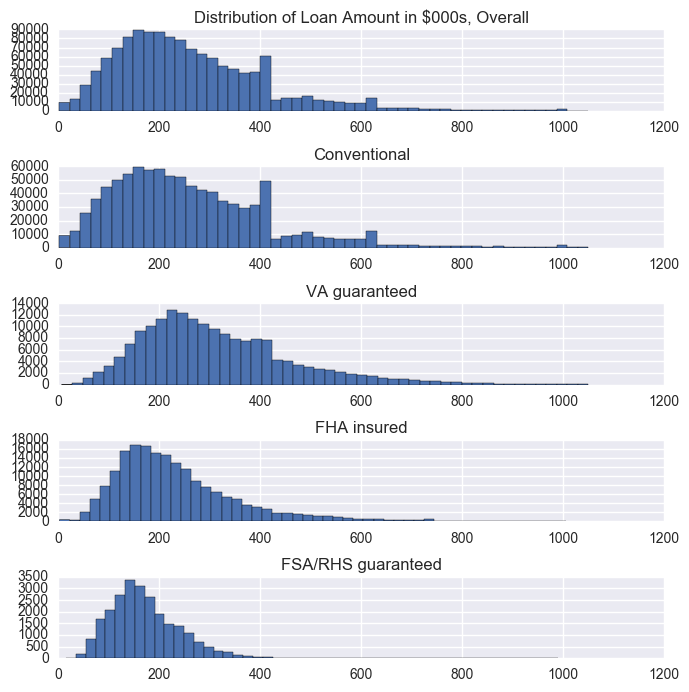

In [18]:
########################################
# distribution of Loan_Amount_000, 
# Applicant_Income_000
########################################
# distribution of loan amount by loan type

# loan type
df_hmda1['Loan_Type_Description'].value_counts()

# plot
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(7,7))

ax[0].hist(df_hmda1['Loan_Amount_000'], bins=50)
ax[0].set_title('Distribution of Loan Amount in $000s, Overall')
ax[0].set_xlim(left=0,right=1200)

ax[1].hist(df_hmda1['Loan_Amount_000'][df_hmda1['Loan_Type_Description']=='Conventional'], bins=50)
ax[1].set_title('Conventional')
ax[1].set_xlim(left=0,right=1200)

ax[2].hist(df_hmda1['Loan_Amount_000'][df_hmda1['Loan_Type_Description']=='VA guaranteed'], bins=50)
ax[2].set_title('VA guaranteed')
ax[2].set_xlim(left=0,right=1200)

ax[3].hist(df_hmda1['Loan_Amount_000'][df_hmda1['Loan_Type_Description']=='FHA insured'], bins=50)
ax[3].set_title('FHA insured')
ax[3].set_xlim(left=0,right=1200)

ax[4].hist(df_hmda1['Loan_Amount_000'][df_hmda1['Loan_Type_Description']=='FSA/RHS guaranteed'], bins=50)
ax[4].set_title('FSA/RHS guaranteed')
ax[4].set_xlim(left=0,right=1200)

fig.tight_layout()
plt.show()

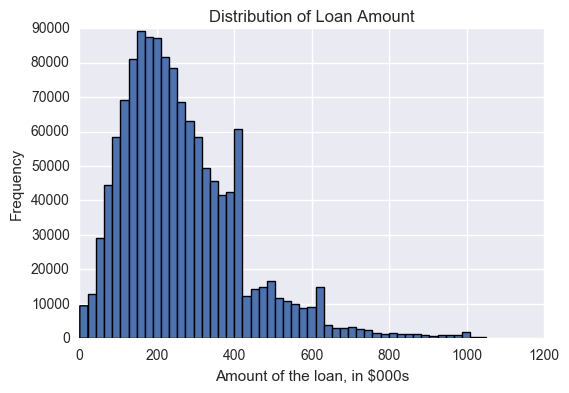

In [75]:
# distribution of loan amount
df_hmda1['Loan_Amount_000'].plot(kind='hist',bins=50,
                                 title='Distribution of Loan Amount')
plt.xlabel('Amount of the loan, in $000s')

In [19]:
# distribution of applicant income
df_hmda1['Applicant_Income_000'][df_hmda1['Applicant_Income_000'].isnull()==False].quantile(q=[0,0.1,0.25,0.5,0.75,0.9,0.99,1])

0.00       1.0
0.10      42.0
0.25      60.0
0.50      94.0
0.75     141.0
0.90     205.0
0.99     440.0
1.00    9999.0
Name: Applicant_Income_000, dtype: float64

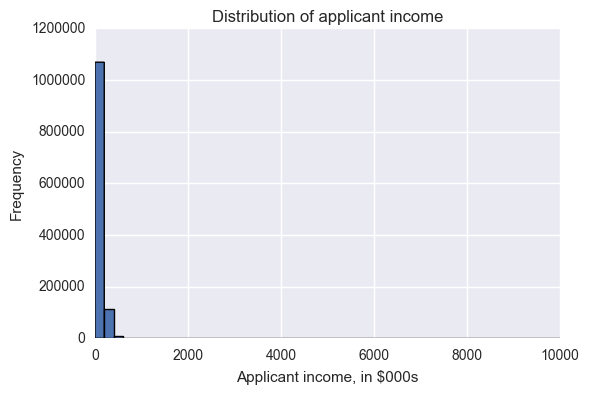

In [76]:
# distribution of applicant income
df_hmda1['Applicant_Income_000'].plot(kind='hist',bins=50,title='Distribution of applicant income')
plt.xlabel('Applicant Income, in $000s')

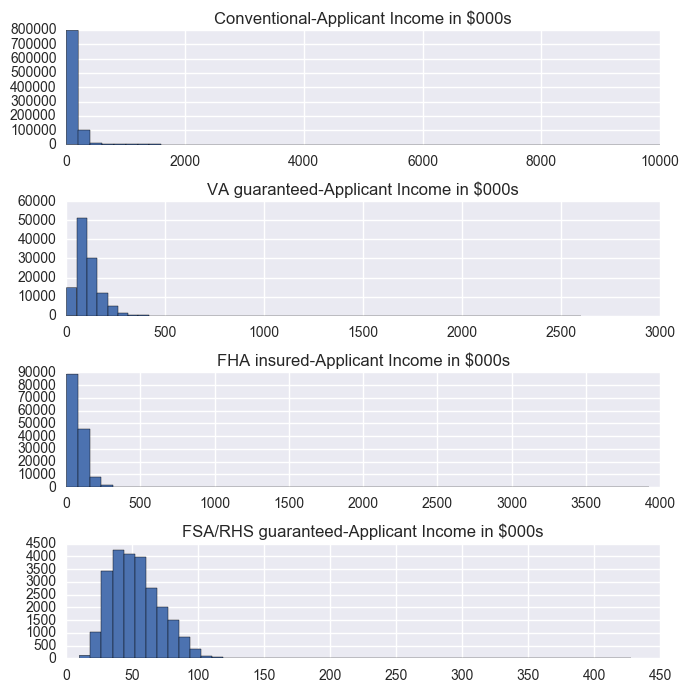

In [20]:
# plot
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(7,7))

ax[0].hist(df_hmda1['Applicant_Income_000'][df_hmda1['Loan_Type_Description']=='Conventional']
            [df_hmda1['Applicant_Income_000'].isnull()==False],
            bins=50)
ax[0].set_title('Conventional-Applicant Income in $000s')


ax[1].hist(df_hmda1['Applicant_Income_000'][df_hmda1['Loan_Type_Description']=='VA guaranteed']
           [df_hmda1['Applicant_Income_000'].isnull()==False], 
           bins=50)
ax[1].set_title('VA guaranteed-Applicant Income in $000s')

ax[2].hist(df_hmda1['Applicant_Income_000'][df_hmda1['Loan_Type_Description']=='FHA insured']
           [df_hmda1['Applicant_Income_000'].isnull()==False], 
           bins=50)
ax[2].set_title('FHA insured-Applicant Income in $000s')

ax[3].hist(df_hmda1['Applicant_Income_000'][df_hmda1['Loan_Type_Description']=='FSA/RHS guaranteed']
           [df_hmda1['Applicant_Income_000'].isnull()==False], 
           bins=50)
ax[3].set_title('FSA/RHS guaranteed-Applicant Income in $000s')


fig.tight_layout()
plt.show()


In [17]:
# check the loan to income rate
# according to the mortgage requirement, if DTI is too high, it may not be reasonable values.
df_hmda1['Loan_to_income'] = df_hmda1['Loan_Amount_000']/df_hmda1['Applicant_Income_000']

C:\Users\YG\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [18]:
df_hmda1['Loan_to_income'].median()

2.5522388059701493

In [19]:
df_hmda1['Loan_to_income'][df_hmda1['Loan_to_income'].isnull()==False].quantile(q=[0,0.1,0.25,0.5,0.75,0.9,0.99,1])

# those applicant with loan 10 times over income does not make much sense and might be value with error
# exclude those rows

0.00      0.003937
0.10      1.153153
0.25      1.770833
0.50      2.552239
0.75      3.443478
0.90      4.343750
0.99      6.309816
1.00    378.000000
Name: Loan_to_income, dtype: float64

In [20]:
df_hmda1.drop(df_hmda1[df_hmda1['Loan_to_income']>=10].index, inplace=True, axis=0)

C:\Users\YG\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


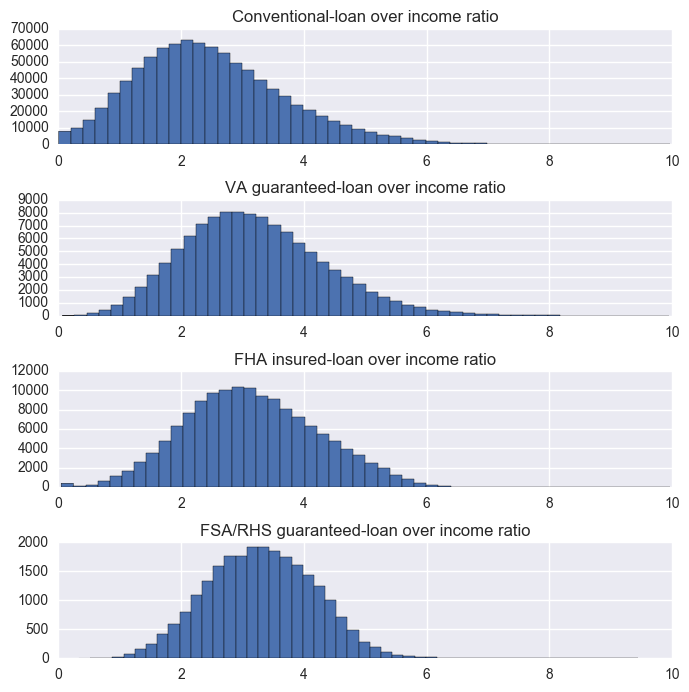

In [21]:
# check the distribution of loan to income
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(7,7))

ax[0].hist(df_hmda1['Loan_to_income'][df_hmda1['Loan_Type_Description']=='Conventional']
            [df_hmda1['Loan_to_income'].isnull()==False],
            bins=50)
ax[0].set_title('Conventional-loan over income ratio')


ax[1].hist(df_hmda1['Loan_to_income'][df_hmda1['Loan_Type_Description']=='VA guaranteed']
           [df_hmda1['Loan_to_income'].isnull()==False], 
           bins=50)
ax[1].set_title('VA guaranteed-loan over income ratio')

ax[2].hist(df_hmda1['Loan_to_income'][df_hmda1['Loan_Type_Description']=='FHA insured']
           [df_hmda1['Loan_to_income'].isnull()==False], 
           bins=50)
ax[2].set_title('FHA insured-loan over income ratio')

ax[3].hist(df_hmda1['Loan_to_income'][df_hmda1['Loan_Type_Description']=='FSA/RHS guaranteed']
           [df_hmda1['Loan_to_income'].isnull()==False], 
           bins=50)
ax[3].set_title('FSA/RHS guaranteed-loan over income ratio')


fig.tight_layout()
plt.show()


In [27]:
###############################################
# Check Respondent_Name_TS
##############################################
# count to see whether 'As_of_Year'+'Agency_Code'+'Respondent_ID' 
# are one to one match with 'Respondent_Name_TS'

# Whether there are multiple Respondent_Name_TS matched to the same 'As_of_Year'+'Agency_Code'+'Respondent_ID'
df_sr = df_hmda1.groupby(by=['As_of_Year','Agency_Code','Respondent_ID'])['Respondent_Name_TS'].nunique()
# make the series a data frame
df_sr = pd.DataFrame(df_sr)
df_sr.columns = ['Count']
df_sr.reset_index(inplace=True)
# Count all the 'As_of_Year'+'Agency_Code'+'Respondent_ID' with multiple'Respondent_Name_TS'
# None exists
df_sr[df_sr['Count'] != 1].count()

As_of_Year       0
Agency_Code      0
Respondent_ID    0
Count            0
dtype: int64

In [28]:
# Whether a Respondent_Name_TS has only one unique 'As_of_Year'+'Agency_Code'+'Respondent_ID'
df_hmda1['instituteID'] = df_hmda1['As_of_Year'].astype(str) + df_hmda1['Agency_Code'].astype(str) + df_hmda1['Respondent_ID'].astype(str)
df_sr = df_hmda1.groupby(by=['Respondent_Name_TS'])['instituteID'].nunique()

# make the series a data frame
df_sr = pd.DataFrame(df_sr)
df_sr.columns = ['Count']
df_sr.reset_index(inplace=True)
# Count all the 'As_of_Year'+'Agency_Code'+'Respondent_ID' with multiple'Respondent_Name_TS'
# None exists
df_sr[df_sr['Count'] > 3]

# There are banks that have several 'As_of_Year'+'Agency_Code'+'Respondent_ID'
# Checked the ffiec website   https://www.ffiec.gov/HmdaAdWebReport/DisWelcome.aspx
# those respondent IDs are of the same bank from different branches, 
# will assume them as the same insitutes for further analysas

C:\Users\YG\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Respondent_Name_TS,Count
253,"CAPITAL BANK, NA",4
319,CITIZENS BANK,4
355,COMMUNITY BANK,4
492,FARMERS AND MERCHANTS BANK,4
505,FIDELITY BANK,5
521,FIRST BANK,8
529,FIRST CENTURY BANK,4
538,FIRST COMMUNITY BANK,5
572,FIRST NATIONAL BANK,4
767,HOMETOWN BANK,4


In [ ]:
##############################################
# Check to see value of the string variables
##############################################

In [29]:
df_hmda1['State'].value_counts(normalize=True,sort=True, ascending=False, bins=None, dropna=True)

VA    0.514802
MD    0.342625
WV    0.059024
DE    0.046884
DC    0.036665
Name: State, dtype: float64

In [30]:
df_hmda1['Loan_Purpose_Description'].value_counts(normalize=True,sort=True, ascending=False, bins=None, dropna=True)

Refinance    0.637997
Purchase     0.362003
Name: Loan_Purpose_Description, dtype: float64

In [31]:
df_hmda1['Agency_Code_Description'].value_counts(normalize=True,sort=True, ascending=False, bins=None, dropna=True)

CFPB           0.411161
HUD            0.360818
FDIC           0.082549
Fed Reserve    0.062840
OCC            0.041990
NCUA           0.040642
Name: Agency_Code_Description, dtype: float64

In [32]:
df_hmda1['Lien_Status_Description'].value_counts(normalize=True,sort=True, ascending=False, bins=None, dropna=True)

First Lien          0.984931
Subordinate Lien    0.015069
Name: Lien_Status_Description, dtype: float64

In [255]:
df_hmda1['Loan_Type_Description'].value_counts(normalize=True,sort=True, ascending=False, bins=None, dropna=True)

Conventional          0.701402
FHA insured           0.143069
VA guaranteed         0.136712
FSA/RHS guaranteed    0.018817
Name: Loan_Type_Description, dtype: float64

In [ ]:
################################################################################
# Market Analysis
#
# Hypothesis of market entry depends on both external and internal factors,
# HMDA data are only a source to analysis the external factors. Further information
# about the company's capability, finanical statement, and other information 
# will be needed to analysis the potential revenue and the cost of market entry.
#
# External market analysis
# 1.The market size by state and growth rate
# 2.Main competitors / top lenders
# 3.How competitive the market it, HHI
################################################################################

In [25]:
# subset the conventioanl loan
df_hmda_conventional = df_hmda1[df_hmda1['Loan_Type_Description']=='Conventional'].copy()
df_hmda_conventional.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 918512 entries, 0 to 1320851
Data columns (total 35 columns):
Agency_Code                       918512 non-null object
Applicant_Income_000              908323 non-null float64
As_of_Year                        918512 non-null int64
Census_Tract_Number               918512 non-null object
County_Code                       918512 non-null object
FFIEC_Median_Family_Income        917200 non-null float64
Loan_Amount_000                   918512 non-null int64
MSA_MD                            918512 non-null object
Number_of_Owner_Occupied_Units    917052 non-null float64
Respondent_ID                     918512 non-null object
Sequence_Number                   918512 non-null object
State_Code                        918512 non-null object
Tract_to_MSA_MD_Income_Pct        917068 non-null float64
MSA_MD_Description                850728 non-null object
Loan_Purpose_Description          918512 non-null object
Agency_Code_Description        

In [26]:
# Conventional and conforming loan market
df_hmda_conventional['Conventional_Conforming_Flag'].value_counts(normalize=True, dropna=False)

Y    0.957476
N    0.042524
Name: Conventional_Conforming_Flag, dtype: float64

In [27]:
# Conventional and conforming loan dataset
df_hmda_conv_conf = df_hmda_conventional[df_hmda_conventional['Conventional_Conforming_Flag']=='Y'].copy()
df_hmda_conv_conf.info()
# 879453 entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879453 entries, 0 to 1320851
Data columns (total 35 columns):
Agency_Code                       879453 non-null object
Applicant_Income_000              869602 non-null float64
As_of_Year                        879453 non-null int64
Census_Tract_Number               879453 non-null object
County_Code                       879453 non-null object
FFIEC_Median_Family_Income        878841 non-null float64
Loan_Amount_000                   879453 non-null int64
MSA_MD                            879453 non-null object
Number_of_Owner_Occupied_Units    878703 non-null float64
Respondent_ID                     879453 non-null object
Sequence_Number                   879453 non-null object
State_Code                        879453 non-null object
Tract_to_MSA_MD_Income_Pct        878720 non-null float64
MSA_MD_Description                813381 non-null object
Loan_Purpose_Description          879453 non-null object
Agency_Code_Description        

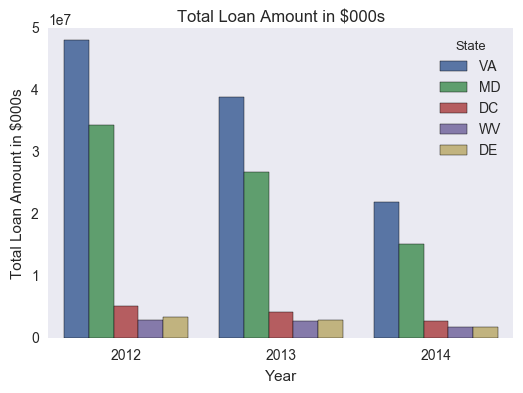

In [28]:
##############################################
# The market size by state and growth rate
##############################################
# Total Loan amount by year
loan_amount_byyear = df_hmda_conv_conf.groupby(by=['As_of_Year','State'])['Loan_Amount_000'].sum()
df_loan_amount_byyear = pd.DataFrame(data=loan_amount_byyear,index=None)
df_loan_amount_byyear.reset_index(inplace=True)

# plot
fig = sns.barplot(x='As_of_Year',y='Loan_Amount_000',data=df_loan_amount_byyear,
                  hue='State', hue_order=['VA','MD','DC','WV','DE'])
fig.set_title('Total Loan Amount in $000s')
fig.set_xlabel('Year')
fig.set_ylabel('Total Loan Amount in $000s')
fig.grid(b='off')

#  The total loan amount was decreasing from 2012 to 2014 in all the five states.

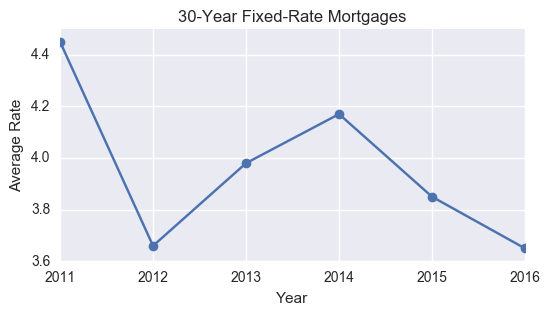

In [149]:
################################################################################
# Interest Rate
################################################################################
# 30-Year Fixed-Rate Mortgages from 'http://www.freddiemac.com/pmms/pmms30.htm'
rate = [['2011',4.45],
['2012',3.66],
['2013',3.98],
['2014',4.17],
['2015',3.85],
['2016',3.65]]


df_rate = pd.DataFrame.from_records(rate,columns=['YYYYMM', 'rate'])

# Plot rate
df_rate.plot(x='YYYYMM',y='rate', marker='o',legend=None, figsize=(6,3))
plt.title('30-Year Fixed-Rate Mortgages')
plt.ylabel('Average Rate')
plt.xlabel('Year')

In [378]:
####################################################################
# Market segment
####################################################################

In [ ]:
# loan purpose by year

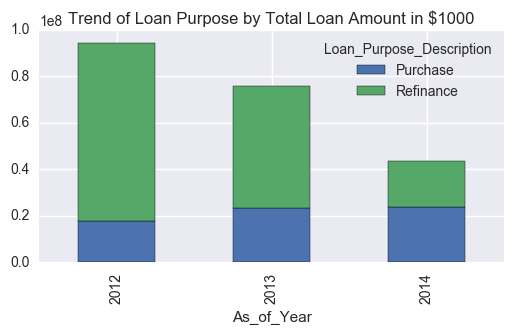

In [164]:
Loan_Purpose_amount = df_hmda_conv_conf.groupby(by=['As_of_Year','Loan_Purpose_Description'])['Loan_Amount_000'].sum()
Loan_Purpose_amount.unstack(level=-1).head(10)
Loan_Purpose_amount.unstack().plot(kind='bar',stacked=True,
                                 figsize=(6,3),
                                 title='Trend of Loan Purpose by Total Loan Amount in $1000',
                                 subplots=False)

In [165]:
# Loan purpose plot by state
Loan_Purpose_amount = df_hmda_conv_conf.groupby(by=['As_of_Year','State','Loan_Purpose_Description'])['Loan_Amount_000'].sum()
Loan_Purpose_amount = pd.DataFrame(data=Loan_Purpose_amount,index=None,columns=['Loan_Amount_000'])
Loan_Purpose_amount.reset_index(inplace=True)
Loan_Purpose_amount

Loan_Purpose_amount_VA = Loan_Purpose_amount[Loan_Purpose_amount['State']=='VA']
Loan_Purpose_amount_MD = Loan_Purpose_amount[Loan_Purpose_amount['State']=='MD']
Loan_Purpose_amount_DC = Loan_Purpose_amount[Loan_Purpose_amount['State']=='DC']
Loan_Purpose_amount_WV = Loan_Purpose_amount[Loan_Purpose_amount['State']=='WV']
Loan_Purpose_amount_DE = Loan_Purpose_amount[Loan_Purpose_amount['State']=='DE']

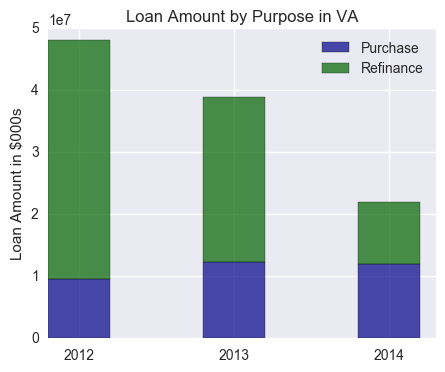

In [166]:
# VA
sr1=Loan_Purpose_amount_VA['Loan_Amount_000'][Loan_Purpose_amount_VA['Loan_Purpose_Description']=='Purchase']
sr2=Loan_Purpose_amount_VA['Loan_Amount_000'][Loan_Purpose_amount_VA['Loan_Purpose_Description']=='Refinance']

ind = np.arange(3)   # the x locations for the groups
width = 0.4       # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(5,4))
p1 = plt.bar(ind, sr1, width, color='darkblue', alpha=0.7)
p2 = plt.bar(ind, sr2, width, color='darkgreen',bottom=sr1, alpha=0.7)

plt.ylabel('Loan Amount in $000s')
plt.title('Loan Amount by Purpose in VA')
plt.xticks(ind+width/2, ('2012', '2013', '2014'))
plt.yticks(np.arange(0, 60000000, 10000000))
plt.legend((p1[0], p2[0]), ('Purchase','Refinance'))

plt.show()

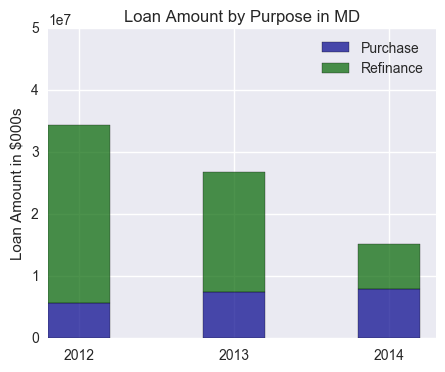

In [167]:
# MD
sr1=Loan_Purpose_amount_MD['Loan_Amount_000'][Loan_Purpose_amount_MD['Loan_Purpose_Description']=='Purchase']
sr2=Loan_Purpose_amount_MD['Loan_Amount_000'][Loan_Purpose_amount_MD['Loan_Purpose_Description']=='Refinance']

n=3
ind = np.arange(n)   # the x locations for the groups
width = 0.4      # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(5,4))
p1 = plt.bar(ind, sr1, width, color='darkblue', alpha=0.7)
p2 = plt.bar(ind, sr2, width, color='darkgreen',bottom=sr1, alpha=0.7)

plt.ylabel('Loan Amount in $000s')
plt.title('Loan Amount by Purpose in MD')
plt.xticks(ind+width/2, ('2012', '2013', '2014'))
plt.yticks(np.arange(0, 60000000, 10000000))
plt.legend((p1[0], p2[0]), ('Purchase','Refinance'))

plt.show()

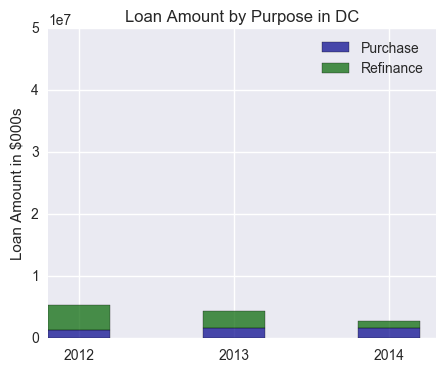

In [168]:
# DC
sr1=Loan_Purpose_amount_DC['Loan_Amount_000'][Loan_Purpose_amount_DC['Loan_Purpose_Description']=='Purchase']
sr2=Loan_Purpose_amount_DC['Loan_Amount_000'][Loan_Purpose_amount_DC['Loan_Purpose_Description']=='Refinance']

n=3
ind = np.arange(n)   # the x locations for the groups
width = 0.4      # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(5,4))
p1 = plt.bar(ind, sr1, width, color='darkblue', alpha=0.7)
p2 = plt.bar(ind, sr2, width, color='darkgreen',bottom=sr1, alpha=0.7)

plt.ylabel('Loan Amount in $000s')
plt.title('Loan Amount by Purpose in DC')
plt.xticks(ind+width/2, ('2012', '2013', '2014'))
plt.yticks(np.arange(0, 60000000, 10000000))
plt.legend((p1[0], p2[0]), ('Purchase','Refinance'))

plt.show()

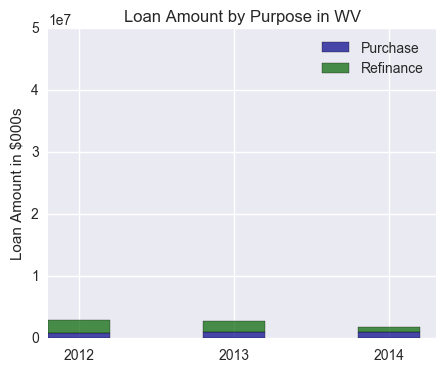

In [169]:
# WV
sr1=Loan_Purpose_amount_WV['Loan_Amount_000'][Loan_Purpose_amount_WV['Loan_Purpose_Description']=='Purchase']
sr2=Loan_Purpose_amount_WV['Loan_Amount_000'][Loan_Purpose_amount_WV['Loan_Purpose_Description']=='Refinance']

n=3
ind = np.arange(n)   # the x locations for the groups
width = 0.4      # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(5,4))
p1 = plt.bar(ind, sr1, width, color='darkblue', alpha=0.7)
p2 = plt.bar(ind, sr2, width, color='darkgreen',bottom=sr1, alpha=0.7)

plt.ylabel('Loan Amount in $000s')
plt.title('Loan Amount by Purpose in WV')
plt.xticks(ind+width/2, ('2012', '2013', '2014'))
plt.yticks(np.arange(0, 60000000, 10000000))
plt.legend((p1[0], p2[0]), ('Purchase','Refinance'))

plt.show()

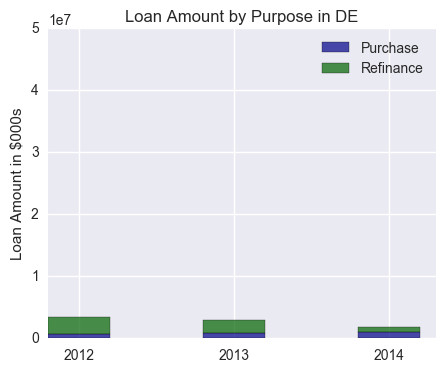

In [170]:
# DE
sr1=Loan_Purpose_amount_DE['Loan_Amount_000'][Loan_Purpose_amount_DE['Loan_Purpose_Description']=='Purchase']
sr2=Loan_Purpose_amount_DE['Loan_Amount_000'][Loan_Purpose_amount_DE['Loan_Purpose_Description']=='Refinance']

n=3
ind = np.arange(n)   # the x locations for the groups
width = 0.4      # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(5,4))
p1 = plt.bar(ind, sr1, width, color='darkblue', alpha=0.7)
p2 = plt.bar(ind, sr2, width, color='darkgreen',bottom=sr1, alpha=0.7)

plt.ylabel('Loan Amount in $000s')
plt.title('Loan Amount by Purpose in DE')
plt.xticks(ind+width/2, ('2012', '2013', '2014'))
plt.yticks(np.arange(0, 60000000, 10000000))
plt.legend((p1[0], p2[0]), ('Purchase','Refinance'))

plt.show()

In [29]:
##############################################
# Top lenders / Main competitors
##############################################
# Loan amount sum by Respondent_Name_TS
loan_amount_institution = df_hmda_conv_conf.groupby(by=['Respondent_Name_TS','As_of_Year'])['Loan_Amount_000'].sum().sort_values(ascending=False)

# series into dataframe
df_loan_amount = pd.DataFrame(data=loan_amount_institution,index=None,columns=['Loan_Amount_000'])
df_loan_amount.reset_index(inplace=True)
df_loan_amount.head()

# seperate the data by year
df_loan_amount_2012 = df_loan_amount[df_loan_amount['As_of_Year']==2012]
df_loan_amount_2013 = df_loan_amount[df_loan_amount['As_of_Year']==2013]
df_loan_amount_2014 = df_loan_amount[df_loan_amount['As_of_Year']==2014]

df_loan_amount_2012['Loan_Amount_pct'] = (df_loan_amount_2012['Loan_Amount_000'] *100 / df_loan_amount_2012['Loan_Amount_000'].astype(int).sum()).round(2)
df_loan_amount_2013['Loan_Amount_pct'] = (df_loan_amount_2013['Loan_Amount_000'] *100 / df_loan_amount_2013['Loan_Amount_000'].astype(int).sum()).round(2)
df_loan_amount_2014['Loan_Amount_pct'] = (df_loan_amount_2014['Loan_Amount_000'] *100 / df_loan_amount_2014['Loan_Amount_000'].astype(int).sum()).round(2)

C:\Users\YG\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\YG\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\YG\Anaconda2\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

In [155]:
# the market share of the top 10 lenders
df_loan_amount_2012.head(10)

,Respondent_Name_TS,As_of_Year,Loan_Amount_000,Loan_Amount_pct
0,"WELLS FARGO BANK, NA",2012,10548891,11.20
3,QUICKEN LOANS,2012,4235785,4.50
4,"SUNTRUST MORTGAGE, INC",2012,4051988,4.30
5,"JPMORGAN CHASE BANK, NA",2012,3653454,3.88
7,BRANCH BANKING AND TRUST CO,2012,3449506,3.66
9,"BANK OF AMERICA, N.A.",2012,3372348,3.58
12,GEORGE MASON MORTGAGE LLC,2012,2412392,2.56
16,NFCU,2012,1841499,1.95
18,FIRST SAVINGS MORTGAGE CORPORA,2012,1785204,1.89
20,"CITIBANK, N.A.",2012,1638267,1.74


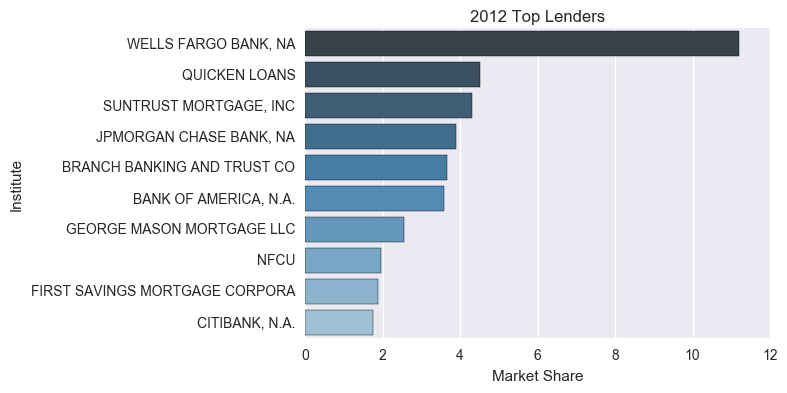

In [156]:
# 2012 top 10 lenders
fig = sns.barplot(x='Loan_Amount_pct', y='Respondent_Name_TS', 
                  data=df_loan_amount_2012.iloc[:10,:],
                 palette='Blues_d')
fig.set_title('2012 Top Lenders')
fig.set_xlim([0,12])
fig.set_ylabel('Institute')
fig.set_xlabel('Market Share')

In [157]:
# the market share of the top 10 lenders
df_loan_amount_2013.head(10)

,Respondent_Name_TS,As_of_Year,Loan_Amount_000,Loan_Amount_pct
1,"WELLS FARGO BANK, NA",2013,7866132,10.37
2,QUICKEN LOANS,2013,4251987,5.60
6,"BANK OF AMERICA, N.A.",2013,3518829,4.64
8,"SUNTRUST MORTGAGE, INC",2013,3377689,4.45
13,BRANCH BANKING AND TRUST CO,2013,2317105,3.05
14,"JPMORGAN CHASE BANK, NA",2013,2312064,3.05
15,GEORGE MASON MORTGAGE LLC,2013,2079451,2.74
17,"CITIBANK, N.A.",2013,1786102,2.35
19,NFCU,2013,1701429,2.24
21,PNC BANK N.A.,2013,1624080,2.14


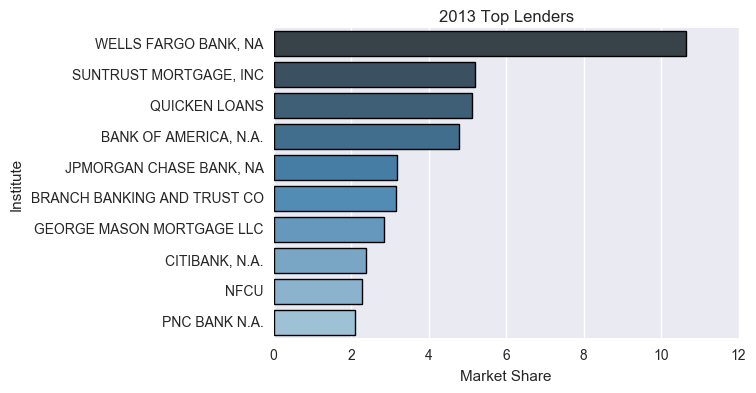

In [353]:
# 2013 top 10 lenders
fig = sns.barplot(x='Loan_Amount_pct', y='Respondent_Name_TS', 
                  data=df_loan_amount_2013.iloc[:10,:],
                 palette='Blues_d')
fig.set_title('2013 Top Lenders')
fig.set_xlim([0,12])
fig.set_ylabel('Institute')
fig.set_xlabel('Market Share')

In [158]:
# the market share of the top 10 lenders
df_loan_amount_2014.head(10)

,Respondent_Name_TS,As_of_Year,Loan_Amount_000,Loan_Amount_pct
10,"WELLS FARGO BANK, NA",2014,3150246,7.24
11,QUICKEN LOANS,2014,2736441,6.29
24,"BANK OF AMERICA, N.A.",2014,1515575,3.48
25,"SUNTRUST MORTGAGE, INC",2014,1489043,3.42
27,GEORGE MASON MORTGAGE LLC,2014,1380017,3.17
34,FIRST HOME MORTGAGE,2014,1135155,2.61
38,NFCU,2014,1081309,2.49
40,BRANCH BANKING AND TRUST CO,2014,988260,2.27
42,"PROSPERITY HOME MORTGAGE, LLC",2014,872117,2.00
43,PNC BANK N.A.,2014,871138,2.00


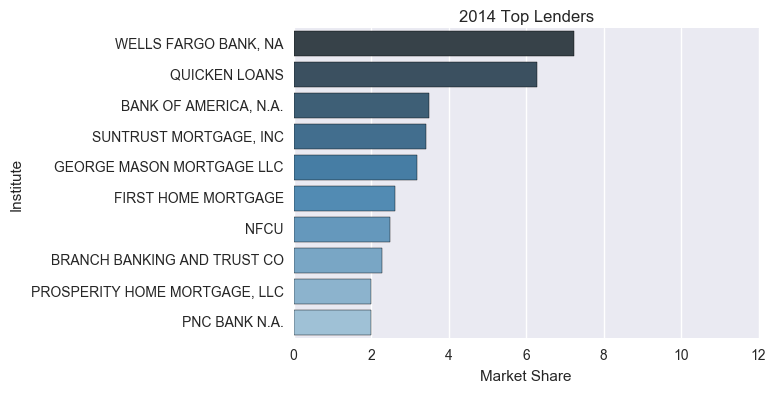

In [159]:
# 2014 top 10 lenders
fig = sns.barplot(x='Loan_Amount_pct', y='Respondent_Name_TS', 
                  data=df_loan_amount_2014.iloc[:10,:],
                 palette='Blues_d')
fig.set_title('2014 Top Lenders')
fig.set_xlim([0,12])
fig.set_ylabel('Institute')
fig.set_xlabel('Market Share')

In [160]:
####################################################################
# How competitive the market it, Herfindahl-Hirschman Index HHI
####################################################################
        
def hhi(vector):
    """ 
    Calculate the Hirschman-Herfindahl index
    
    param 
    -------
    vector: Positive vector
    
    return: HHI (Float)
    """
    return np.square(vector).sum()

In [161]:
hhi_2012 = hhi(df_loan_amount_2012['Loan_Amount_pct'])

258.7877999999977

In [162]:
hhi_2013 = hhi(df_loan_amount_2013['Loan_Amount_pct'])

253.62870000000115

In [163]:
hhi_2014 = hhi(df_loan_amount_2014['Loan_Amount_pct'])

190.6449000000014

In [ ]:
# An H below 0.01 (or 100) indicates a highly competitive industry.
# An H below 0.15 (or 1,500) indicates an unconcentrated industry.
# An H between 0.15 to 0.25 (or 1,500 to 2,500) indicates moderate concentration.
# An H above 0.25 (above 2,500) indicates high concentration.[5]
# Reference: https://en.wikipedia.org/wiki/Herfindahl_index

# HHI of the convenional mortgage market during the three years were all 
# in [100,1500]. It was unconcentrated market.

In [ ]:
##################################################################
# Cluster the applicant
##################################################################
# K Means clusters, an unsupervised machine learning algorithm. 
# Identify clusters of lending patterns

# Only the conventional conforming loans data were considered.
# The lending patterns that of interests are:

# numeric:
# ---------
# Applicant_Income_000
# FFIEC_Median_Family_Income
# Loan_Amount_000
# Number_of_Owner_Occupied_Units
# Tract_to_MSA_MD_Income_Pct
# Conforming_Limit_000
# Loan_Amount_Bucket
# Loan_to_income

# categorical:
# ------------
# Loan_Purpose_Description
# Lien_Status_Description

In [205]:
from sklearn.cluster import KMeans

In [83]:
# subset the data with only variables of interest
df_model = df_hmda_conv_conf[['Applicant_Income_000', 'FFIEC_Median_Family_Income','Loan_Amount_000',
                             'Number_of_Owner_Occupied_Units','Tract_to_MSA_MD_Income_Pct','Conforming_Limit_000',
                             'Loan_Amount_Bucket','Loan_to_income','Loan_Purpose_Description','Lien_Status_Description',
                            'State','As_of_Year']]
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879453 entries, 0 to 1320851
Data columns (total 12 columns):
Applicant_Income_000              869602 non-null float64
FFIEC_Median_Family_Income        878841 non-null float64
Loan_Amount_000                   879453 non-null int64
Number_of_Owner_Occupied_Units    878703 non-null float64
Tract_to_MSA_MD_Income_Pct        878720 non-null float64
Conforming_Limit_000              879453 non-null float64
Loan_Amount_Bucket                879453 non-null float64
Loan_to_income                    869602 non-null float64
Loan_Purpose_Description          879453 non-null object
Lien_Status_Description           879453 non-null object
State                             879453 non-null object
As_of_Year                        879453 non-null int64
dtypes: float64(7), int64(2), object(3)
memory usage: 87.2+ MB


In [84]:
# count the missing values
sr = df_model.isnull().sum()/879453 #total number of entries 879453
sr.sort_values(ascending=False)

Loan_to_income                    0.011201
Applicant_Income_000              0.011201
Number_of_Owner_Occupied_Units    0.000853
Tract_to_MSA_MD_Income_Pct        0.000833
FFIEC_Median_Family_Income        0.000696
As_of_Year                        0.000000
State                             0.000000
Lien_Status_Description           0.000000
Loan_Purpose_Description          0.000000
Loan_Amount_Bucket                0.000000
Conforming_Limit_000              0.000000
Loan_Amount_000                   0.000000
dtype: float64

In [85]:
# drop missing values
df_model1=df_model.dropna()
df_model1.info()
# 868848 entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 868848 entries, 0 to 1320851
Data columns (total 12 columns):
Applicant_Income_000              868848 non-null float64
FFIEC_Median_Family_Income        868848 non-null float64
Loan_Amount_000                   868848 non-null int64
Number_of_Owner_Occupied_Units    868848 non-null float64
Tract_to_MSA_MD_Income_Pct        868848 non-null float64
Conforming_Limit_000              868848 non-null float64
Loan_Amount_Bucket                868848 non-null float64
Loan_to_income                    868848 non-null float64
Loan_Purpose_Description          868848 non-null object
Lien_Status_Description           868848 non-null object
State                             868848 non-null object
As_of_Year                        868848 non-null int64
dtypes: float64(7), int64(2), object(3)
memory usage: 86.2+ MB


In [86]:
# convert categorical variable into dummy variables
a1 = pd.get_dummies(df_model1['Loan_Purpose_Description'],prefix='Loan_Purpose',drop_first=True)
a2 = pd.get_dummies(df_model1['Lien_Status_Description'],prefix='Lien',drop_first=True)
df_model1.drop(['Loan_Purpose_Description','Lien_Status_Description'],axis=1,inplace=True)
df_model2 = pd.concat([df_model1,a1,a2],axis=1)
df_model2.head()

C:\Users\YG\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Applicant_Income_000,FFIEC_Median_Family_Income,Loan_Amount_000,Number_of_Owner_Occupied_Units,Tract_to_MSA_MD_Income_Pct,Conforming_Limit_000,Loan_Amount_Bucket,Loan_to_income,State,As_of_Year,Loan_Purpose_Refinance,Lien_Subordinate Lien
0,84.0,54900.0,94,1545.0,93.07,417.0,1.0,1.119048,WV,2012,1.0,0.0
1,84.0,54900.0,133,1548.0,58.00,417.0,2.0,1.583333,WV,2012,1.0,0.0
2,53.0,54900.0,70,1548.0,58.00,417.0,1.0,1.320755,WV,2012,1.0,0.0
3,85.0,54900.0,102,1935.0,145.21,417.0,2.0,1.200000,WV,2012,1.0,0.0
4,38.0,54900.0,112,1492.0,127.96,417.0,2.0,2.947368,WV,2012,0.0,0.0


In [79]:
# collinearity
df_model.corr()

# Check to see correlation coefficient absolute value > 0.7
# FFIEC_Median_Family_Income, Conforming_Limit_000 0.93
# Loan_Amount_000, Loan_Amount_Bucket  0.98

,Applicant_Income_000,FFIEC_Median_Family_Income,Loan_Amount_000,Number_of_Owner_Occupied_Units,Tract_to_MSA_MD_Income_Pct,Conforming_Limit_000,Loan_Amount_Bucket,Loan_to_income,As_of_Year,Loan_Purpose__Refinance,Lien__Subordinate Lien
Applicant_Income_000,1.000000,0.221446,0.437320,0.000032,0.278256,0.210883,0.427748,-0.372314,-0.051245,0.031655,0.013059
FFIEC_Median_Family_Income,0.221446,1.000000,0.450914,-0.181458,0.033893,0.930114,0.439952,0.140369,-0.045054,0.023806,-0.027201
Loan_Amount_000,0.437320,0.450914,1.000000,-0.023436,0.348828,0.427409,0.974794,0.331509,-0.016106,-0.106720,-0.213176
Number_of_Owner_Occupied_Units,0.000032,-0.181458,-0.023436,1.000000,0.262901,-0.202151,-0.022963,-0.019869,-0.019009,0.036766,-0.006207
Tract_to_MSA_MD_Income_Pct,0.278256,0.033893,0.348828,0.262901,1.000000,0.037052,0.340662,-0.017488,-0.076242,0.027056,-0.014463
Conforming_Limit_000,0.210883,0.930114,0.427409,-0.202151,0.037052,1.000000,0.417603,0.121883,-0.042186,0.012920,-0.019398
Loan_Amount_Bucket,0.427748,0.439952,0.974794,-0.022963,0.340662,0.417603,1.000000,0.318574,-0.014211,-0.110459,-0.189685
Loan_to_income,-0.372314,0.140369,0.331509,-0.019869,-0.017488,0.121883,0.318574,1.000000,0.045058,-0.121578,-0.236222
As_of_Year,-0.051245,-0.045054,-0.016106,-0.019009,-0.076242,-0.042186,-0.014211,0.045058,1.000000,-0.251847,0.030270
Loan_Purpose__Refinance,0.031655,0.023806,-0.106720,0.036766,0.027056,0.012920,-0.110459,-0.121578,-0.251847,1.000000,-0.073670


In [87]:
# FFIEC_Median_Family_Income, Conforming_Limit_000 0.93
# Loan_Amount_000, Loan_Amount_Bucket  0.98
# Remove FFIEC_Median_Family_Income, Loan_Amount_000

df_model3 = df_model2.drop(['FFIEC_Median_Family_Income','Loan_Amount_000'],axis=1)
df_model3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 868848 entries, 0 to 1320851
Data columns (total 10 columns):
Applicant_Income_000              868848 non-null float64
Number_of_Owner_Occupied_Units    868848 non-null float64
Tract_to_MSA_MD_Income_Pct        868848 non-null float64
Conforming_Limit_000              868848 non-null float64
Loan_Amount_Bucket                868848 non-null float64
Loan_to_income                    868848 non-null float64
State                             868848 non-null object
As_of_Year                        868848 non-null int64
Loan_Purpose_Refinance            868848 non-null float64
Lien_Subordinate Lien             868848 non-null float64
dtypes: float64(8), int64(1), object(1)
memory usage: 72.9+ MB


In [55]:
# Standardize the Variables
# To eliminate the effect of scale of the variables.
from sklearn.preprocessing import StandardScaler

In [89]:
scaler = StandardScaler()
scaler.fit(df_model3.drop(['State','As_of_Year'],axis=1))
scaled_features = scaler.transform(df_model3.drop(['State','As_of_Year'],axis=1))
df_feat = pd.DataFrame(scaled_features,columns=['Applicant_Income_000','Number_of_Owner_Occupied_Units',
                                                'Tract_to_MSA_MD_Income_Pct','Conforming_Limit_000',
                                                'Loan_Amount_Bucket','Loan_to_income',
                                                'Loan_Purpose_Refinance','Lien_Subordinate Lien'])
df_feat.head()

,Applicant_Income_000,Number_of_Owner_Occupied_Units,Tract_to_MSA_MD_Income_Pct,Conforming_Limit_000,Loan_Amount_Bucket,Loan_to_income,Loan_Purpose_Refinance,Lien_Subordinate Lien
0,-0.337301,0.289065,-0.695210,-1.35661,-1.456174,-1.086372,0.621987,-0.149039
1,-0.337301,0.294416,-1.634089,-1.35661,-0.704213,-0.718069,0.621987,-0.149039
2,-0.672584,0.294416,-1.634089,-1.35661,-1.456174,-0.926364,0.621987,-0.149039
3,-0.326485,0.984698,0.700658,-1.35661,-0.704213,-1.022155,0.621987,-0.149039
4,-0.834818,0.194530,0.238849,-1.35661,-0.704213,0.363977,-1.607750,-0.149039


In [58]:
# Model
from sklearn.cluster import KMeans

In [114]:
# 
# Two clusters
#
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_feat)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [115]:
pred = kmeans.predict(df_feat)

In [116]:
df_model3['Cluster2'] = pred
df_model3['Cluster2'] = df_model3['Cluster2'].apply(lambda x: 'Pattern 1' if x==1 else 'Pattern 2')

In [117]:
df_model3['Cluster2'].value_counts(normalize=True)

Pattern 2    0.542674
Pattern 1    0.457326
Name: Cluster2, dtype: float64

In [118]:
df_model3.head()

,Applicant_Income_000,Number_of_Owner_Occupied_Units,Tract_to_MSA_MD_Income_Pct,Conforming_Limit_000,Loan_Amount_Bucket,Loan_to_income,State,As_of_Year,Loan_Purpose_Refinance,Lien_Subordinate Lien,Cluster2,Cluster3
0,84.0,1545.0,93.07,417.0,1.0,1.119048,WV,2012,1.0,0.0,Pattern 2,Pattern 2
1,84.0,1548.0,58.00,417.0,2.0,1.583333,WV,2012,1.0,0.0,Pattern 2,Pattern 2
2,53.0,1548.0,58.00,417.0,1.0,1.320755,WV,2012,1.0,0.0,Pattern 2,Pattern 2
3,85.0,1935.0,145.21,417.0,2.0,1.200000,WV,2012,1.0,0.0,Pattern 2,Pattern 2
4,38.0,1492.0,127.96,417.0,2.0,2.947368,WV,2012,0.0,0.0,Pattern 2,Pattern 2


In [122]:
# visualization by state
clusterdf = df_model3.groupby(by=['State'])['Cluster2'].value_counts()
clusterdf.unstack(level=-1).head(10)

Cluster2,Pattern 1,Pattern 2
State,,
DC,31472,5270
DE,2816,37933
MD,144508,157245
VA,215620,219169
WV,2931,51884


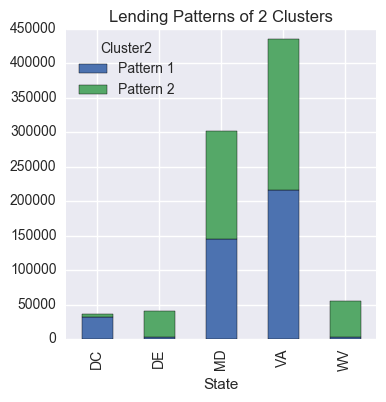

In [124]:
clusterdf.unstack().plot(kind='bar',stacked=True,figsize=(4,4),subplots=False,
                        title='Lending Patterns of 2 Clusters')

In [121]:
# 
# Three clusters
#
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_feat)
pred = kmeans.predict(df_feat)
df_model3['Cluster3'] = pred
df_model3['Cluster3'] = df_model3['Cluster3'].apply(lambda x: 'Pattern 1' if x==0 else 'Pattern 2' if x==1 else 'Pattern 3')
df_model3['Cluster3'].value_counts(normalize=True)

Pattern 3    0.532501
Pattern 1    0.445770
Pattern 2    0.021730
Name: Cluster3, dtype: float64

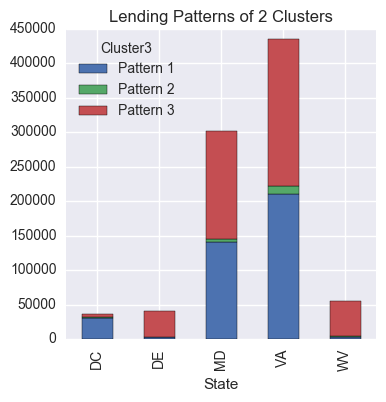

In [125]:
# visualization by state
clusterdf = df_model3.groupby(by=['State'])['Cluster3'].value_counts()
clusterdf.unstack(level=-1).head(10)
clusterdf.unstack().plot(kind='bar',stacked=True,figsize=(4,4),subplots=False,
                        title='Lending Patterns of 2 Clusters')